In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from src.features.q3_plots import *
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
import src.features.feature_engineering_2 as feng2
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Chargemenet du dataset
data = pd.read_csv('../data/datasets/csv_files/2016-2019-v2.csv')
data.columns

Index(['period', 'period_type', 'period_time', 'game_seconds', 'gameID',
       'attacking_team_id', 'attacking_team_name', 'home_team', 'shooter',
       'goalie', 'shot_type', 'x_coordinate', 'y_coordinate', 'strength',
       'last_event_type', 'last_event_x', 'last_event_y',
       'time_since_last_event', 'distance_from_last_event',
       'powerplay_duration', 'home_team_players', 'away_team_players',
       'distance_to_net', 'shot_angle', 'is_goal', 'is_empty_net', 'rebound',
       'angle_change', 'speed'],
      dtype='object')

### Question 1

In [6]:
# Sélection des caractéristiques distance_to_net et shot_angle et des labels is_goal
df1 = data[['distance_to_net', 'shot_angle' , 'is_goal']]
df1.head()

,distance_to_net,shot_angle,is_goal
0,13.0,23.0,0
1,13.0,77.0,0
2,76.0,-30.0,0
3,58.0,-15.0,0
4,62.0,27.0,0


In [7]:
X1, y1 = df1[['distance_to_net', 'shot_angle']].values , df1['is_goal'].values
# Séparation des données en ensembles d'entraînement et de test
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [8]:
# Instanciation du classificateur XGBoost
xgb_classifier1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Entraînement du modèle
xgb_classifier1.fit(X_train1, y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [9]:
# Prédictions sur l'ensemble de validation
y_pred1 = xgb_classifier1.predict(X_val1)
y_pred_proba1 = xgb_classifier1.predict_proba(X_val1)[:, 1]

In [17]:
accuracy1 = accuracy_score(y_val1, y_pred1)
recall1 = recall_score(y_val1, y_pred1)
f1_score1 = f1_score(y_val1, y_pred1)
auc1 = roc_auc_score(y_val1, y_pred_proba1)

print("Accuracy:", accuracy1)
print("Recall:", recall1)
print("F1 Score:", f1_score1)
print("AUC Score:", auc1)

Accuracy: 0.9042926145216579
Recall: 0.0018988200189882002
F1 Score: 0.003784295175023652
AUC Score: 0.7171453459747072


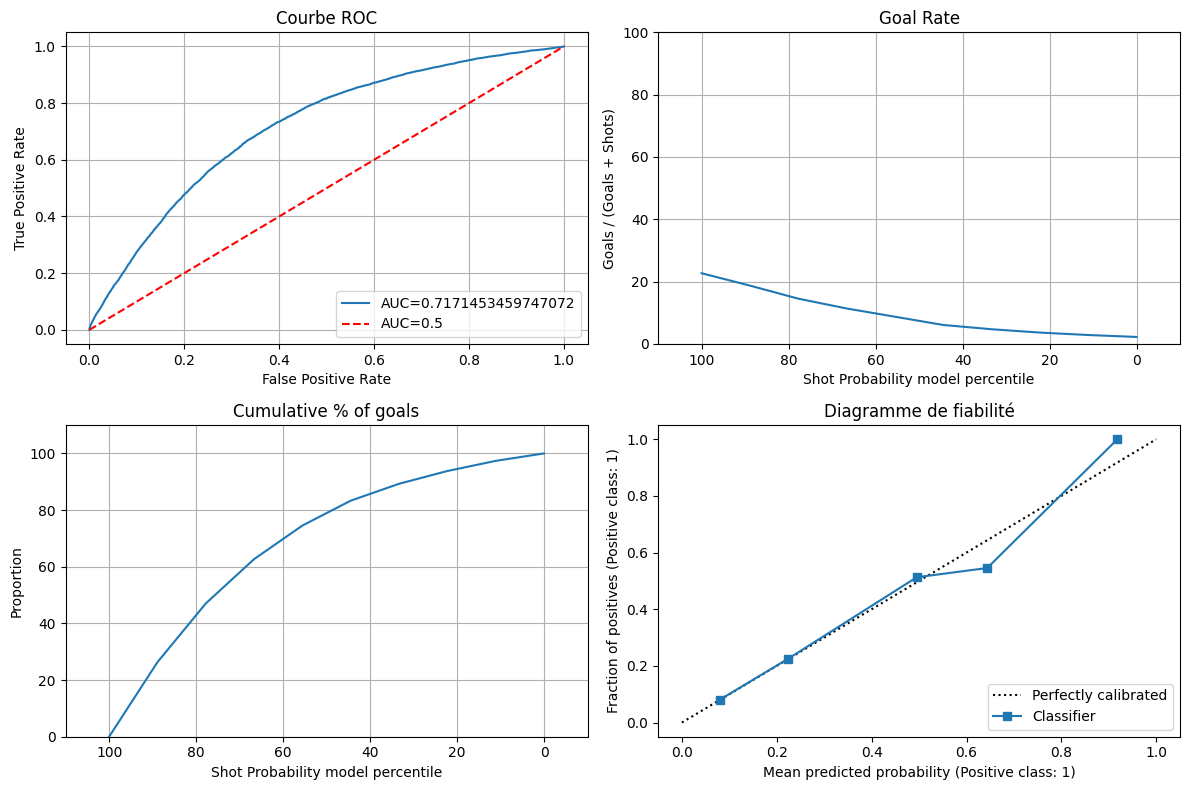

In [23]:
plot_metrics(y_val1, y_pred_proba1)

### Question 2

In [26]:
data.columns

Index(['period', 'period_type', 'period_time', 'game_seconds', 'gameID',
       'attacking_team_id', 'attacking_team_name', 'shooter', 'goalie',
       'shot_type', 'x_coordinate', 'y_coordinate', 'strength',
       'last_event_type', 'last_event_x', 'last_event_y',
       'time_since_last_event', 'distance_from_last_event',
       'powerplay_duration', 'home_team_players', 'away_team_players',
       'distance_to_net', 'shot_angle', 'is_goal', 'is_empty_net', 'rebound',
       'angle_change', 'speed'],
      dtype='object')

In [4]:
X2, y2 = feng2.select_features(data)

c:\users\mk_ya\desktop\ift6758-projet\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
# Séparation des données en ensembles d'entraînement et de test
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [6]:
X_train2.dtypes

period                                  int64
game_seconds                            int64
x_coordinate                          float64
y_coordinate                          float64
distance_to_net                       float64
shot_angle                            float64
shot_type                               int64
last_event_x                          float64
last_event_y                          float64
time_since_last_event                   int64
distance_from_last_event              float64
rebound                                 int32
angle_change                          float64
speed                                 float64
powerplay_duration                      int64
home_team_players                       int64
away_team_players                       int64
last_event_type_Blocked Shot          float64
last_event_type_Faceoff               float64
last_event_type_Game Official         float64
last_event_type_Giveaway              float64
last_event_type_Goal              

In [8]:
param_grid = {
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'min_child_weight': [1, 2, 5, 10],
    'subsample': [0.6, 0.8, 1]
}

# Initialize the XGBoost classifier
xgb_classifier2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_classifier2, param_distributions=param_grid, 
                                   n_iter=20, cv=5, n_jobs=-1, scoring='f1', verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train2, y_train2)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy found: ", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.5}
Best accuracy found:  0.12462310190250932


In [ ]:
xgb_classifier2 = grid_search.best_estimator_
# Prédictions sur l'ensemble de validation
y_pred2 = xgb_classifier2.predict(X_val2.values)
y_pred_proba2 = xgb_classifier2.predict_proba(X_val2.values)[:, 1]

In [ ]:
plot_metrics(y_val2.values, y_pred_proba2)

### Question 3

In [9]:
feature_importances = random_search.best_estimator_.feature_importances_

feature_names = X_train2.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

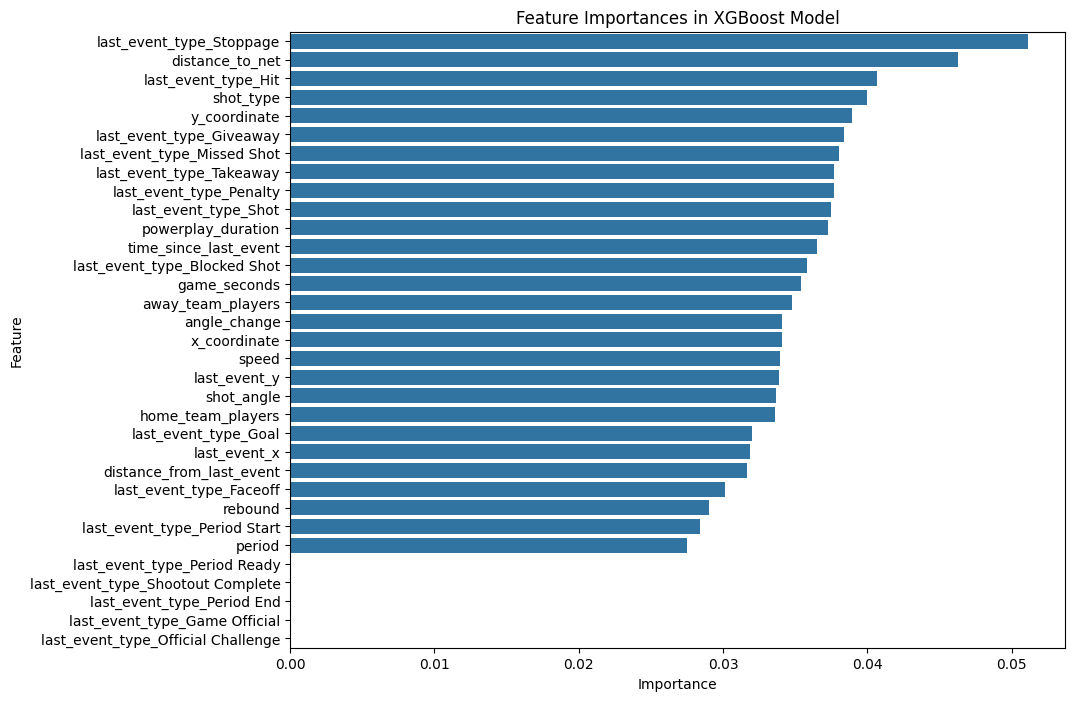

In [10]:
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importances in XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [12]:
best_params = random_search.best_params_

xgb_model3 = xgb.XGBClassifier(**best_params)
rfecv = RFECV(estimator=xgb_model3, step=1, cv=StratifiedKFold(5), scoring='f1', verbose=2)
rfecv.fit(X_train2, y_train2)

Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 featur

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.5, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=15, max_leaves=None, min_child_weight=5,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...),
      scoring='f1', verbose=2)

Optimal number of features: 33
Best features: Index(['period', 'game_seconds', 'x_coordinate', 'y_coordinate',
       'distance_to_net', 'shot_angle', 'shot_type', 'last_event_x',
       'last_event_y', 'time_since_last_event', 'distance_from_last_event',
       'rebound', 'angle_change', 'speed', 'powerplay_duration',
       'home_team_players', 'away_team_players',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shootout Complete', 'last_event_type_Shot',
       'last_event_type_Stoppage', 'last_event_type_Takeaway'],
      dtype='object')


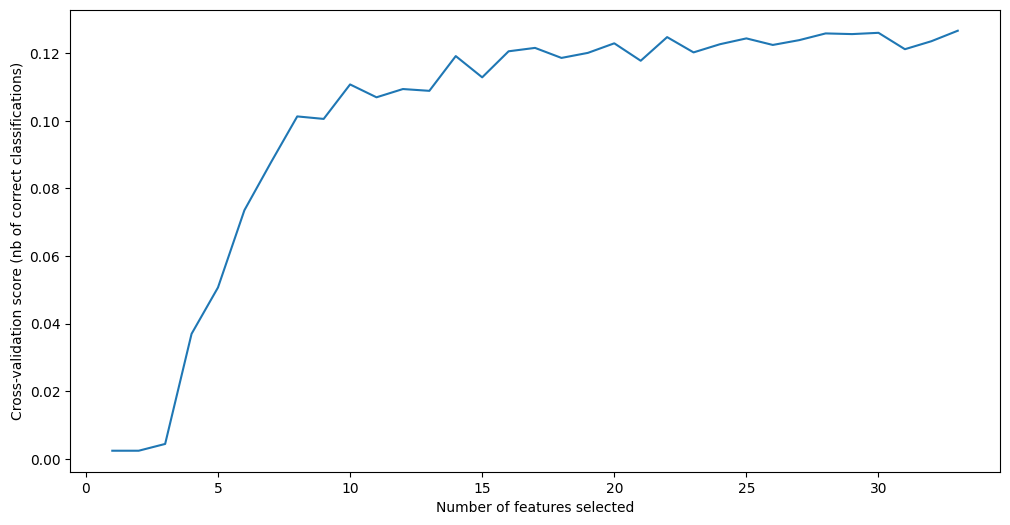

In [14]:
print("Optimal number of features:", rfecv.n_features_)
print("Best features:", X_train2.columns[rfecv.support_])

cross_val_scores = rfecv.cv_results_['mean_test_score']

plt.figure(figsize=(12, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(cross_val_scores) + 1), cross_val_scores)
plt.show()

###### On utilisera ces features avec notre modèle dans une expérience sur Comet.